# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size_and_gene_density"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.002492,0.007581,0.328664,0.742421,0.371210,random.pheno988
1,LV2,0.005430,0.007049,0.770417,0.441081,0.220541,random.pheno988
2,LV3,-0.009939,0.008177,-1.215420,0.224250,0.887875,random.pheno988
3,LV4,-0.008979,0.008557,-1.049380,0.294043,0.852979,random.pheno988
4,LV5,0.002331,0.012122,0.192328,0.847491,0.423746,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06910536980749747

# QQ-plot

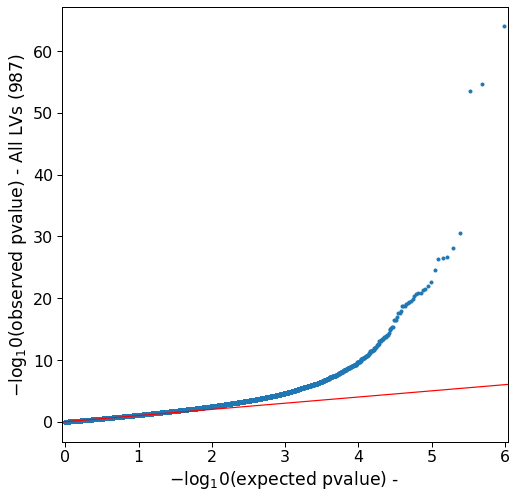

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.010,0.041,0.073
1,LV10,0.018,0.072,0.118
2,LV100,0.013,0.033,0.069
3,LV101,0.027,0.103,0.168
4,LV102,0.014,0.054,0.100


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.020948,0.069105,0.120961
std,0.018327,0.030107,0.037715
min,0.000000,0.010000,0.039000
25%,0.011000,0.051000,0.097000
50%,0.017000,0.063000,0.114000
75%,0.024000,0.081000,0.138000
max,0.230000,0.337000,0.394000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(60, 4)

,lv,1,5,10
12,LV11,0.009,0.049,0.086
941,LV947,0.010,0.049,0.092
898,LV908,0.011,0.049,0.116
895,LV905,0.015,0.049,0.095
746,LV771,0.009,0.049,0.098
547,LV592,0.014,0.049,0.098
963,LV967,0.010,0.049,0.104
432,LV489,0.008,0.049,0.102
308,LV377,0.015,0.049,0.076
261,LV334,0.015,0.049,0.106


,lv,1,5,10
827,LV844,0.012,0.051,0.101
865,LV879,0.012,0.051,0.109
766,LV79,0.015,0.051,0.110
744,LV77,0.012,0.051,0.089
169,LV251,0.013,0.051,0.092
570,LV612,0.018,0.051,0.120
530,LV577,0.010,0.051,0.086
158,LV241,0.013,0.051,0.113
507,LV556,0.014,0.051,0.100
491,LV541,0.020,0.051,0.089


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(528, 4)

,lv,1,5,10
466,LV519,0.089,0.159,0.233
436,LV492,0.063,0.161,0.228
710,LV739,0.076,0.162,0.240
924,LV931,0.077,0.168,0.244
255,LV329,0.111,0.173,0.206
289,LV36,0.104,0.175,0.225
349,LV413,0.101,0.179,0.229
549,LV594,0.109,0.180,0.243
24,LV120,0.095,0.190,0.257
297,LV367,0.116,0.191,0.247


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.010698,0.008597,1.244451,0.213379,0.106689,random.pheno988
1031,LV45,0.003008,0.008652,0.347704,0.728074,0.364037,random.pheno589
2018,LV45,0.001104,0.008576,0.128733,0.897573,0.448786,random.pheno385
3005,LV45,0.003853,0.008681,0.443816,0.657190,0.328595,random.pheno5
3992,LV45,-0.017967,0.008603,-2.088490,0.036793,0.981604,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.046

In [32]:
show_prop(results, 0.05)

0.106

In [33]:
show_prop(results, 0.10)

0.159

In [34]:
show_prop(results, 0.15)

0.207

In [35]:
show_prop(results, 0.20)

0.246

### QQplot

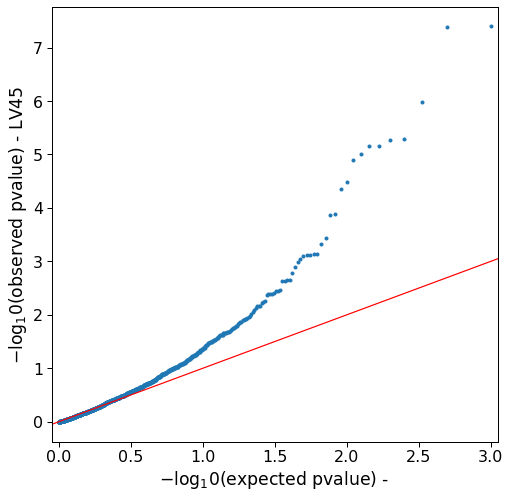

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.016456,0.010705,1.537227,0.124287,0.062143,random.pheno988
1220,LV234,0.003720,0.010774,0.345248,0.729919,0.364959,random.pheno589
2207,LV234,-0.004856,0.010680,-0.454674,0.649359,0.675321,random.pheno385
3194,LV234,0.005194,0.010811,0.480471,0.630909,0.315455,random.pheno5
4181,LV234,0.003814,0.010717,0.355897,0.721929,0.360965,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.017

In [43]:
show_prop(results, 0.05)

0.055

In [44]:
show_prop(results, 0.10)

0.103

In [45]:
show_prop(results, 0.15)

0.155

In [46]:
show_prop(results, 0.20)

0.202

### QQplot

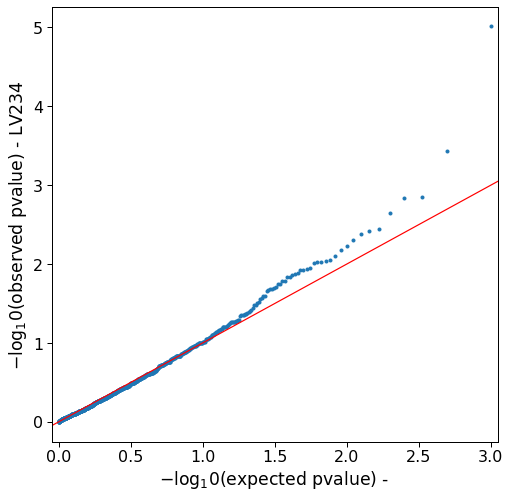

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.002023,0.010902,0.185571,0.852787,0.426394,random.pheno988
1833,LV847,-0.003097,0.010971,-0.282306,0.777718,0.611141,random.pheno589
2820,LV847,-0.013266,0.010874,-1.219934,0.222534,0.888733,random.pheno385
3807,LV847,-0.004033,0.011009,-0.366340,0.714124,0.642938,random.pheno5
4794,LV847,0.007028,0.010912,0.644059,0.519560,0.259780,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.008

In [54]:
show_prop(results, 0.05)

0.054

In [55]:
show_prop(results, 0.10)

0.092

In [56]:
show_prop(results, 0.15)

0.135

In [57]:
show_prop(results, 0.20)

0.17

### QQplot

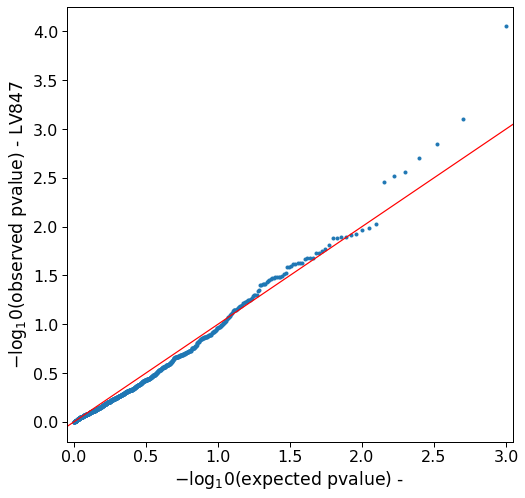

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.023309,0.008891,-2.621651,0.008771,0.995614,random.pheno988
1096,LV110,-0.013408,0.008950,-1.498050,0.134169,0.932915,random.pheno589
2083,LV110,-0.009061,0.008873,-1.021152,0.307221,0.846389,random.pheno385
3070,LV110,-0.008491,0.008982,-0.945276,0.344553,0.827723,random.pheno5
4057,LV110,0.008748,0.008904,0.982460,0.325910,0.162955,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.012

In [65]:
show_prop(results, 0.05)

0.041

In [66]:
show_prop(results, 0.10)

0.088

In [67]:
show_prop(results, 0.15)

0.133

In [68]:
show_prop(results, 0.20)

0.179

### QQplot

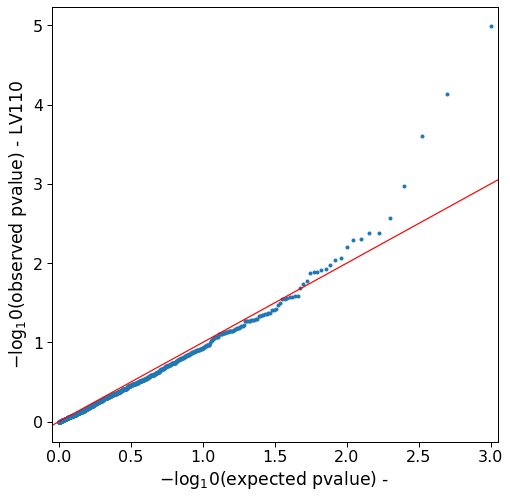

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.013992,0.010268,1.362621,0.173050,0.086525,random.pheno988
1755,LV769,-0.007244,0.010334,-0.701039,0.483304,0.758348,random.pheno589
2742,LV769,-0.011296,0.010243,-1.102740,0.270181,0.864909,random.pheno385
3729,LV769,-0.014569,0.010368,-1.405130,0.160031,0.919985,random.pheno5
4716,LV769,-0.017813,0.010277,-1.733307,0.083089,0.958456,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.057

In [76]:
show_prop(results, 0.05)

0.14

In [77]:
show_prop(results, 0.10)

0.204

In [78]:
show_prop(results, 0.15)

0.259

In [79]:
show_prop(results, 0.20)

0.31

### QQplot

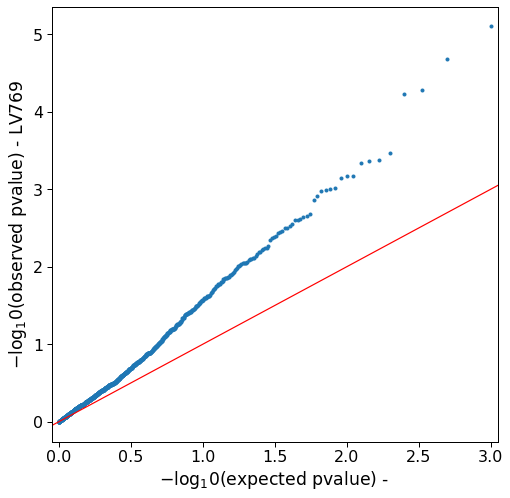

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.004395,0.012582,0.349308,0.726869,0.363435,random.pheno988
1786,LV800,-0.013667,0.012660,-1.079558,0.280379,0.859810,random.pheno589
2773,LV800,-0.004682,0.012551,-0.373071,0.709108,0.645446,random.pheno385
3760,LV800,-0.016340,0.012703,-1.286274,0.198394,0.900803,random.pheno5
4747,LV800,-0.009630,0.012593,-0.764701,0.444478,0.777761,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.046

In [88]:
show_prop(results, 0.10)

0.104

In [89]:
show_prop(results, 0.15)

0.147

In [90]:
show_prop(results, 0.20)

0.191

### QQplot

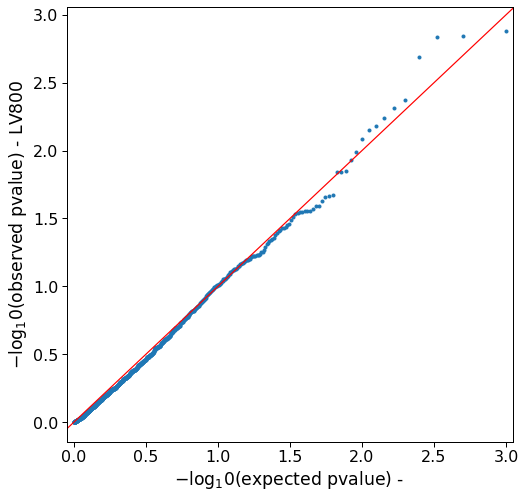

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
12,LV11,0.009,0.049,0.086
941,LV947,0.010,0.049,0.092
898,LV908,0.011,0.049,0.116
895,LV905,0.015,0.049,0.095
746,LV771,0.009,0.049,0.098
547,LV592,0.014,0.049,0.098
963,LV967,0.010,0.049,0.104
432,LV489,0.008,0.049,0.102
308,LV377,0.015,0.049,0.076
261,LV334,0.015,0.049,0.106


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.006900,0.009347,0.738221,0.460407,0.230204,random.pheno988
1398,LV412,-0.006421,0.009406,-0.682703,0.494819,0.752590,random.pheno589
2385,LV412,0.005838,0.009324,0.626140,0.531245,0.265623,random.pheno385
3372,LV412,-0.001868,0.009439,-0.197888,0.843139,0.578431,random.pheno5
4359,LV412,0.011947,0.009353,1.277339,0.201529,0.100764,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.009

In [100]:
show_prop(results, 0.05)

0.056

In [101]:
show_prop(results, 0.10)

0.109

In [102]:
show_prop(results, 0.15)

0.151

In [103]:
show_prop(results, 0.20)

0.194

### QQplot

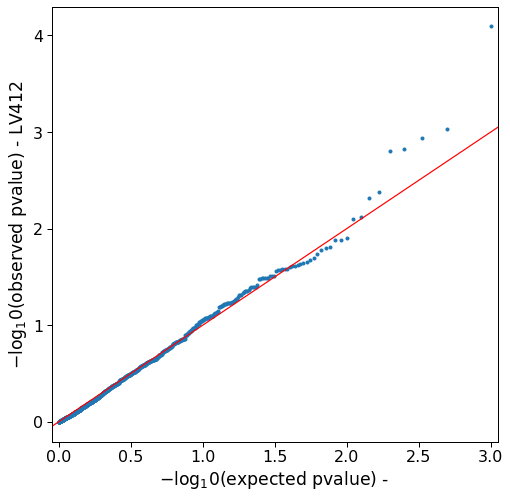

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.017162,0.009693,-1.770539,0.076685,0.961658,random.pheno988
1043,LV57,0.000435,0.009756,0.044549,0.964468,0.482234,random.pheno589
2030,LV57,0.020011,0.009668,2.069768,0.038514,0.019257,random.pheno385
3017,LV57,-0.004175,0.009790,-0.426482,0.669771,0.665115,random.pheno5
4004,LV57,-0.000818,0.009705,-0.084311,0.932812,0.533594,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.054

In [112]:
show_prop(results, 0.10)

0.105

In [113]:
show_prop(results, 0.15)

0.152

In [114]:
show_prop(results, 0.20)

0.208

### QQplot

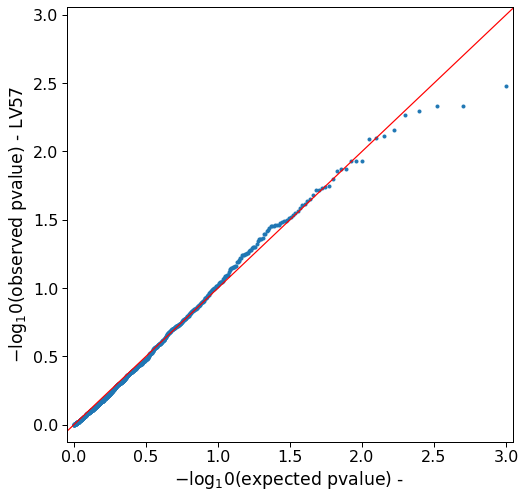

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007022,0.010785,-0.651036,0.515047,0.742477,random.pheno988
1633,LV647,0.008553,0.010853,0.788081,0.430679,0.215339,random.pheno589
2620,LV647,0.013598,0.010758,1.264039,0.206262,0.103131,random.pheno385
3607,LV647,-0.000082,0.010891,-0.007497,0.994019,0.502991,random.pheno5
4594,LV647,0.018959,0.010793,1.756516,0.079048,0.039524,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.023

In [122]:
show_prop(results, 0.05)

0.081

In [123]:
show_prop(results, 0.10)

0.121

In [124]:
show_prop(results, 0.15)

0.167

In [125]:
show_prop(results, 0.20)

0.214

### QQplot

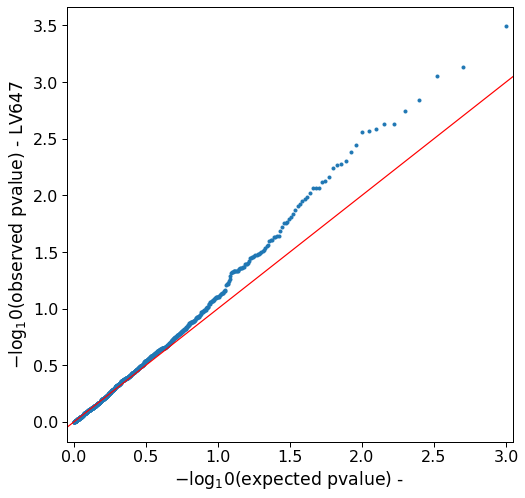

In [126]:
qqplot_unif(results)